In [160]:
from error_prop_tools import *
from helpers import *
import pyzx as zx
import numpy as np
import scipy as sp
import sympy as sy
import random
import matplotlib.pyplot as plt
from fractions import Fraction
import quimb.tensor as qtn
import pprint as pp
import re
from matplotlib.patches import Circle

--- Generated Grid Map for d=3 ---
[[0, 0, 'X0', 0, 0, 0, 0],
 [0, 'd0', 0, 'd1', 0, 'd2', 0],
 [0, 0, 'Z0', 0, 'X1', 0, 'Z1'],
 [0, 'd3', 0, 'd4', 0, 'd5', 0],
 ['Z2', 0, 'X2', 0, 'Z3', 0, 0],
 [0, 'd6', 0, 'd7', 0, 'd8', 0],
 [0, 0, 0, 0, 'X3', 0, 0]]


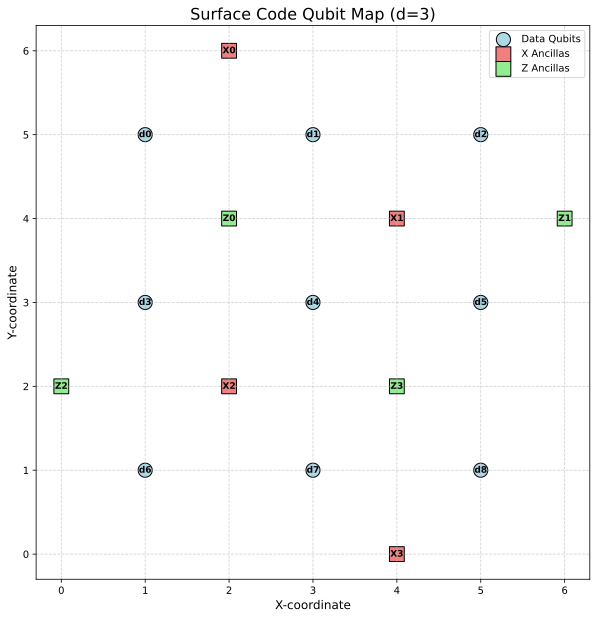

In [161]:
DISTANCE = 3

_, sorted_ancillas = generate_pyzx_and_plot_rotated_code(DISTANCE)

pyzx_map_rotated = {2: (1, 5),
                    5: (3, 5),
                    8: (5, 5),
                    1: (1, 3),
                    4: (3, 3),
                    7: (5, 3),
                    0: (1, 1),
                    3: (3, 1),
                    6: (5, 1),
                    12: (2, 6),
                    11: (2, 4),
                    15: (4, 4),
                    16: (6, 4),
                    9: (0, 2),
                    10: (2, 2),
                    14: (4, 2),
                    13: (4, 0),
                    17: (3, 2),
                    }
order = [1, 3, 0, 2]
custom_orders = {
    'Z0': order,
    'X1': order,
    'X2': order,
    'Z3': order
}
custom_qasm_string = generate_surface_code_qasm(DISTANCE, custom_cnot_orderings=custom_orders)

In [162]:
import random

chars = ['0', '1', '+', '-']
state_string = ''.join(random.choice(chars) for _ in range(9))+'0'*8
print(state_string)

-0101+--+00000000


In [163]:
g = zx.sqasm(custom_qasm_string, simplify=False)
zx.id_simp(g)
# g.map_qubits(pyzx_map_rotated)

error = PauliWeb.random(g)

stab_round = g.copy()

corrs, log = PropagatePauliError(stab_round, [(key, value) for key, value in error.es.items()], add_init=False)
outputs_errs = get_output_errors(stab_round, corrs)
stab_round.apply_state(state_string)



noisy_round = error.graph_with_errors()
noisy_round.apply_state(state_string)
zx.draw(noisy_round, True)
zx.draw(stab_round, True, pauli_web = corrs)
rho = graphical_partial_trace(noisy_round, range(9))
zx.draw(rho, True)
zx.full_reduce(rho)
gg = rho.copy()
gg.normalize()
zx.simplify.id_simp(gg)
zx.draw(gg, True)    

sample = np.abs(np.real(np.diag(rho.to_matrix(preserve_scalar=True))))
pp.pprint(np.sum(sample))

np.float64(0.9999999999999983)


Can read out some syndrome bits from this diagram, reduce sample space. Speed up simulations.

In [164]:
#c coinflip, e entangled, 0 or 1 if measurment is deterministic
#need to take another partial trace to sample entangled qubits

out_dist = ['c'] * len(gg.inputs())
for j, i in enumerate(gg.inputs()):
    neighbors = list(gg.neighbors(i))
    entangled = False
    for v in neighbors:
        for vv in gg.neighbors(v):
            if gg.qubit(vv) != gg.qubit(i):
                print(f"Entanglement detected at vertex {i} on qubit {gg.qubit(i)} with qubit {gg.qubit(vv)}")
                entangled = True
                break
        if entangled:
            out_dist[j] = 'e'
            break
    if not entangled:
        v = neighbors[0]
        if gg.type(v) == zx.VertexType.Z:
            out_dist[j] = '0' if gg.phase(v) == 0 else '1'
out_dist = ''.join(out_dist)
print(out_dist)
samples = sample_bitstrings(sample, 1)
print(samples)

ccccccc1
['01101111']


128


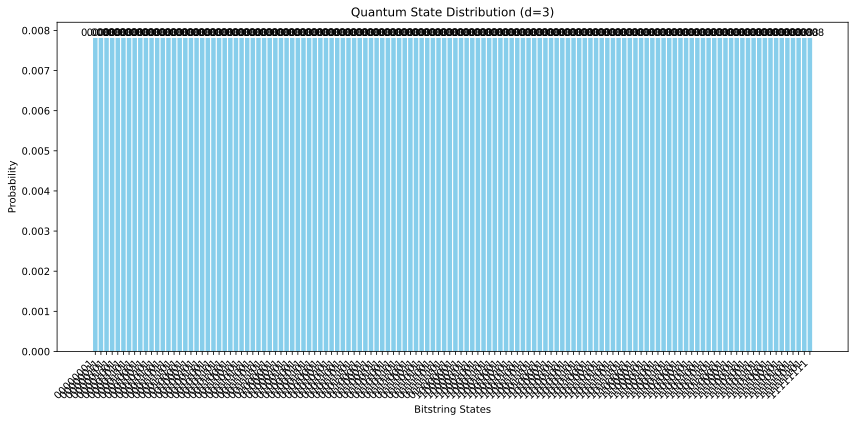

In [165]:
import matplotlib.pyplot as plt
import numpy as np

probs = np.abs(sample.real)
threshold = 1e-10
significant_indices = np.where(probs > threshold)[0]
significant_probs = probs[significant_indices]
print(len(significant_probs))

# Generate bitstrings for the significant indices
significant_bitstrings = [format(idx, f'0{int(np.log2(len(sample)))}b') for idx in significant_indices]

# Create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(significant_probs)), significant_probs, color='skyblue')

# Customize the plot
plt.xlabel('Bitstring States')
plt.ylabel('Probability')
plt.title(f'Quantum State Distribution (d={DISTANCE})')
plt.xticks(range(len(significant_probs)), significant_bitstrings, rotation=45, ha='right')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [166]:
qubit_dict = {i: f'd{i}' for i in range(9)}
for i, s in enumerate(['X0', 'Z0', 'X1', 'Z1', 'Z2', 'X2', 'Z3', 'X3']):
    qubit_dict[i+9] = s
plotting_dict = {}
for e in outputs_errs.items():
    plotting_dict[qubit_dict[stab_round.qubit(e[0])]] = e[1]
    print(f"Error on qubit {qubit_dict[stab_round.qubit(e[0])]}: {e[1]}")


Error on qubit d4: Y
Error on qubit d5: Z
Error on qubit d7: Y
Error on qubit d8: X
Error on qubit Z0: X
Error on qubit X1: X
Error on qubit Z1: Y
Error on qubit Z2: Z
Error on qubit X2: X
Error on qubit Z3: Y
Error on qubit X3: X


In [167]:
plotting_dict

{'d4': 'Y',
 'd5': 'Z',
 'd7': 'Y',
 'd8': 'X',
 'Z0': 'X',
 'X1': 'X',
 'Z1': 'Y',
 'Z2': 'Z',
 'X2': 'X',
 'Z3': 'Y',
 'X3': 'X'}

Look into how output dist of syndromes is related to propagate pauli error output